In [3]:
import pandas as pd
import logging

# Log fayl manzili
log_path = r"C:\Users\Rasulbek907\Desktop\Project_MP\Log\unsml.log"

# Log sozlamalari
logging.basicConfig(
    filename=log_path,
    filemode='a',  # Append mode
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

try:
    logging.info("CSV fayl o'qilmoqda:...")
    df = pd.read_csv(r"C:\Users\Rasulbek907\Desktop\Project_MP\Data\Web_Scrapping\youtube_full_dataset_10000.csv")
    logging.info(f"Fayl muvaffaqiyatli o'qildi. Satırlar soni: {len(df)} ustunlar soni: {len(df.columns)}")
except Exception as e:
    logging.error(f"CSV faylni o'qishda xatolik: {e}")

| # | Turi                  | Model            | Maqsad                                            |
| - | --------------------- | ---------------- | ------------------------------------------------- |
| 1 | Kanal segmentatsiyasi | KMeans           | Faol kanallarni topish                            |
| 2 | Video clustering      | KMeans           | Videolarni trend/asosiy/g‘alati turlarga ajratish |
| 3 | Mamlakatlar tahlili   | Hierarchical     | O‘xshash mamlakatlarni topish                     |
| 4 | Anomaly detection     | Isolation Forest | G‘alati yoki viral videolarni aniqlash            |
| 5 | Category similarity   | Agglomerative    | O‘xshash kontent turlarini aniqlash               |


# 🧩 1️⃣ Kanal segmentatsiyasi — KMeans bilan

Kanallarni faoliyati (Views, Likes, Comments, Subscribers, Channel Views) bo‘yicha guruhlash.

In [4]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Faqat raqamli ustunlar
X = df[['Views', 'Likes', 'Comments', 'Subscribers', 'Channel Views']]

# Normalizatsiya
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans modeli
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Natija grafikda
fig = px.scatter_3d(
    df,
    x='Views',
    y='Likes',
    z='Subscribers',
    color='Cluster',
    hover_data=['Channel'],
    title='📊 Kanal Segmentatsiyasi (KMeans)'
)
fig.show()


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8493 entries, 0 to 8492
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Video ID        8493 non-null   object
 1   Video Title     8493 non-null   object
 2   Channel         8492 non-null   object
 3   Published Date  8493 non-null   object
 4   Views           8493 non-null   int64 
 5   Likes           8493 non-null   int64 
 6   Comments        8493 non-null   int64 
 7   Subscribers     8493 non-null   int64 
 8   Channel Views   8493 non-null   int64 
 9   Country         8493 non-null   object
 10  Region          8493 non-null   object
 11  CategoryID      8493 non-null   int64 
 12  CategoryName    8493 non-null   object
 13  Cluster         8493 non-null   int32 
dtypes: int32(1), int64(6), object(7)
memory usage: 895.9+ KB


# 🎬 2️⃣ Video Clustering — KMeans bilan

Videolarni o‘z xususiyatlariga ko‘ra guruhlash (trend, oddiy, kam e’tiborli).

In [6]:
from sklearn.preprocessing import LabelEncoder

# Kategoriya va mamlakatni raqamlashtiramiz
le_cat = LabelEncoder()
le_country = LabelEncoder()

df['CategoryID_enc'] = le_cat.fit_transform(df['CategoryName'])
df['Country_enc'] = le_country.fit_transform(df['Country'])

# Feature tanlash
X = df[['Views', 'Likes', 'Comments', 'CategoryID_enc', 'Country_enc']]

# Normalizatsiya
X_scaled = scaler.fit_transform(X)

# KMeans
kmeans_videos = KMeans(n_clusters=5, random_state=42)
df['VideoCluster'] = kmeans_videos.fit_predict(X_scaled)

# Vizualizatsiya
fig = px.scatter(
    df,
    x='Likes',
    y='Views',
    color='VideoCluster',
    hover_data=['Video Title', 'CategoryName', 'Country'],
    title='🎥 Video Clustering (KMeans)'
)
fig.show()


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8493 entries, 0 to 8492
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Video ID        8493 non-null   object
 1   Video Title     8493 non-null   object
 2   Channel         8492 non-null   object
 3   Published Date  8493 non-null   object
 4   Views           8493 non-null   int64 
 5   Likes           8493 non-null   int64 
 6   Comments        8493 non-null   int64 
 7   Subscribers     8493 non-null   int64 
 8   Channel Views   8493 non-null   int64 
 9   Country         8493 non-null   object
 10  Region          8493 non-null   object
 11  CategoryID      8493 non-null   int64 
 12  CategoryName    8493 non-null   object
 13  Cluster         8493 non-null   int32 
 14  CategoryID_enc  8493 non-null   int64 
 15  Country_enc     8493 non-null   int64 
 16  VideoCluster    8493 non-null   int32 
dtypes: int32(2), int64(8), object(7)
memory usage: 1.0+ 

# 🌍 3️⃣ Mamlakatlar tahlili — Hierarchical Clustering bilan

O‘xshash mamlakatlarni topish.

c:\Users\Rasulbek907\Desktop\Project_MP\mpvenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.



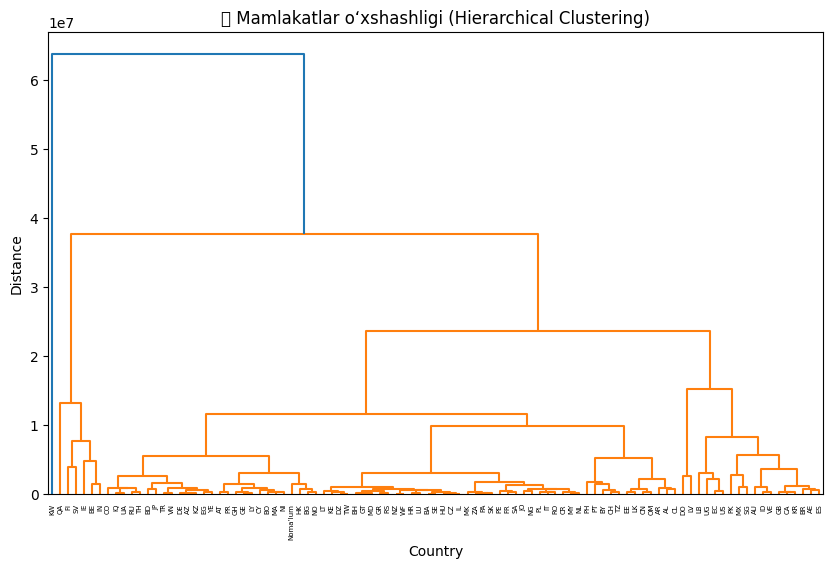

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Har bir davlat uchun o‘rtacha ko‘rsatkich
country_grouped = df.groupby('Country')[['Views', 'Likes', 'Comments', 'Subscribers']].mean()

# Hierarchical linkage
linkage_data = linkage(country_grouped, method='ward')

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_data, labels=country_grouped.index, leaf_rotation=90)
plt.title('🌍 Mamlakatlar o‘xshashligi (Hierarchical Clustering)')
plt.xlabel('Country')
plt.ylabel('Distance')
plt.show()


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8493 entries, 0 to 8492
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Video ID        8493 non-null   object
 1   Video Title     8493 non-null   object
 2   Channel         8492 non-null   object
 3   Published Date  8493 non-null   object
 4   Views           8493 non-null   int64 
 5   Likes           8493 non-null   int64 
 6   Comments        8493 non-null   int64 
 7   Subscribers     8493 non-null   int64 
 8   Channel Views   8493 non-null   int64 
 9   Country         8493 non-null   object
 10  Region          8493 non-null   object
 11  CategoryID      8493 non-null   int64 
 12  CategoryName    8493 non-null   object
 13  Cluster         8493 non-null   int32 
 14  CategoryID_enc  8493 non-null   int64 
 15  Country_enc     8493 non-null   int64 
 16  VideoCluster    8493 non-null   int32 
dtypes: int32(2), int64(8), object(7)
memory usage: 1.0+ 

# ⚠️ 4️⃣ Anomaly Detection — Isolation Forest bilan

G‘alati (odatdan tashqari) videolarni topish.

In [10]:
from sklearn.ensemble import IsolationForest

# Faqat asosiy raqamli ustunlar
X = df[['Views', 'Likes', 'Comments', 'Subscribers', 'Channel Views']]

# Model
iso = IsolationForest(contamination=0.03, random_state=42)
df['Anomaly'] = iso.fit_predict(X)

# -1 → anomaliya, 1 → normal
df['Anomaly'] = df['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Vizualizatsiya
fig = px.scatter(
    df,
    x='Likes',
    y='Views',
    color='Anomaly',
    hover_data=['Video Title', 'Channel'],
    title='🚨 Anomaly Detection (IsolationForest)'
)
fig.show()

# Anomal videolarni ko‘rish
print("🚨 Anomal videolar:")
print(df[df['Anomaly'] == 'Anomaly'][['Video Title', 'Views', 'Likes', 'Comments']].head(10))


🚨 Anomal videolar:
                                           Video Title     Views    Likes  \
38   فالكونز في غابات أوروبا بـ 1000 ريال و بـ 100 ...   6064243   345442   
52   DOG Tries to BULLY Tiny Kitten...then THIS Hap...  63779457   959734   
121                             BamBam 'WONDERING' M/V  59679486   237082   
141                                The cat just said 💅  73156104  2457094   
149  劇場版『チェンソーマン レゼ篇』オープニングムービー 　主題歌：米津玄師「IRIS OUT」...  13116308   466452   
151     GURU RANDHAWA - PAN INDIA - MV - BHUSHAN KUMAR  38284831   457048   
160  PERFECT - Guru Randhawa, Varun Dhawan, Janhvi ...  38632132   433237   
200  BOYNEXTDOOR (보이넥스트도어) 'Hollywood Action' Offic...   1538874    44868   
217  One of these days Bron Breakker's spear is gon...   4171647    54161   
246  Phillies land All-Star closer Jhoan Duran ahea...  40257483   793537   

     Comments  
38      27865  
52      12588  
121     17701  
141     16814  
149     15509  
151     18470  
160     15735  
200  

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8493 entries, 0 to 8492
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Video ID        8493 non-null   object
 1   Video Title     8493 non-null   object
 2   Channel         8492 non-null   object
 3   Published Date  8493 non-null   object
 4   Views           8493 non-null   int64 
 5   Likes           8493 non-null   int64 
 6   Comments        8493 non-null   int64 
 7   Subscribers     8493 non-null   int64 
 8   Channel Views   8493 non-null   int64 
 9   Country         8493 non-null   object
 10  Region          8493 non-null   object
 11  CategoryID      8493 non-null   int64 
 12  CategoryName    8493 non-null   object
 13  Cluster         8493 non-null   int32 
 14  CategoryID_enc  8493 non-null   int64 
 15  Country_enc     8493 non-null   int64 
 16  VideoCluster    8493 non-null   int32 
 17  Anomaly         8493 non-null   object
dtypes: int32

# 🧠 5️⃣ Category Similarity — Agglomerative Clustering bilan

Kategoriya o‘xshashliklarini topish.

In [13]:
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px

# Kategoriya bo‘yicha o‘rtacha ko‘rsatkichlar
category_grouped = df.groupby('CategoryName')[['Views', 'Likes', 'Comments']].mean()

# Model (metric o‘rniga)
agg = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
category_grouped['Cluster'] = agg.fit_predict(category_grouped)

# Grafik
fig = px.scatter_3d(
    category_grouped,
    x='Views',
    y='Likes',
    z='Comments',
    color='Cluster',
    hover_data=[category_grouped.index],
    title='🎭 Category Similarity (Agglomerative Clustering)'
)
fig.show()


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8493 entries, 0 to 8492
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Video ID        8493 non-null   object
 1   Video Title     8493 non-null   object
 2   Channel         8492 non-null   object
 3   Published Date  8493 non-null   object
 4   Views           8493 non-null   int64 
 5   Likes           8493 non-null   int64 
 6   Comments        8493 non-null   int64 
 7   Subscribers     8493 non-null   int64 
 8   Channel Views   8493 non-null   int64 
 9   Country         8493 non-null   object
 10  Region          8493 non-null   object
 11  CategoryID      8493 non-null   int64 
 12  CategoryName    8493 non-null   object
 13  Cluster         8493 non-null   int32 
 14  CategoryID_enc  8493 non-null   int64 
 15  Country_enc     8493 non-null   int64 
 16  VideoCluster    8493 non-null   int32 
 17  Anomaly         8493 non-null   object
dtypes: int32

# 🧠 UNSML natijalarini CSV faylga saqlash

In [16]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
import numpy as np

# --- 1️⃣ KMeans (Kanal segmentatsiyasi)
channel_features = df[['Subscribers', 'Channel Views', 'Views', 'Likes']].copy()
channel_features = channel_features.fillna(channel_features.mean())

kmeans = KMeans(n_clusters=4, random_state=42)
df['Channel_Cluster'] = kmeans.fit_predict(channel_features)


# --- 2️⃣ Video Clustering (KMeans bilan)
video_features = df[['Views', 'Likes', 'Comments']].copy()
video_features = video_features.fillna(video_features.mean())

video_kmeans = KMeans(n_clusters=5, random_state=42)
df['Video_Cluster'] = video_kmeans.fit_predict(video_features)


# --- 3️⃣ Mamlakatlar Hierarchical Clustering
country_grouped = df.groupby('Country')[['Views', 'Likes', 'Comments']].mean()
agg_country = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
country_grouped['Country_Cluster'] = agg_country.fit_predict(country_grouped)

# Merge cluster back to main df
df = df.merge(country_grouped['Country_Cluster'], on='Country', how='left')


# --- 4️⃣ Anomaly Detection (IsolationForest)
iso = IsolationForest(contamination=0.02, random_state=42)
df['Anomaly'] = iso.fit_predict(video_features)
df['Anomaly'] = df['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})


# --- 5️⃣ Category Similarity (Agglomerative)
category_grouped = df.groupby('CategoryName')[['Views', 'Likes', 'Comments']].mean()
agg = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
category_grouped['Category_Cluster'] = agg.fit_predict(category_grouped)

# Merge cluster to main df
df = df.merge(category_grouped['Category_Cluster'], on='CategoryName', how='left')


# --- 6️⃣ Yakuniy faylni saqlaymiz
df.to_csv(r"C:\Users\Rasulbek907\Desktop\Project_MP\Data\Preprosessed\Clustering.csv", index=False, encoding='utf-8-sig')

print("✅ UNSML natijalari 'Clustering.csv' fayliga saqlandi!")


✅ UNSML natijalari 'Clustering.csv' fayliga saqlandi!


| ustun nomi         | ma’nosi                                  |
| ------------------ | ---------------------------------------- |
| `Channel_Cluster`  | Kanal tiplari bo‘yicha KMeans segmenti   |
| `Video_Cluster`    | Videolar klasterlari                     |
| `Country_Cluster`  | Davlatlar klasteri                       |
| `Anomaly`          | Videoning anomaliya yoki normal ekanligi |
| `Category_Cluster` | Kategoriya o‘xshashlik klasteri          |
